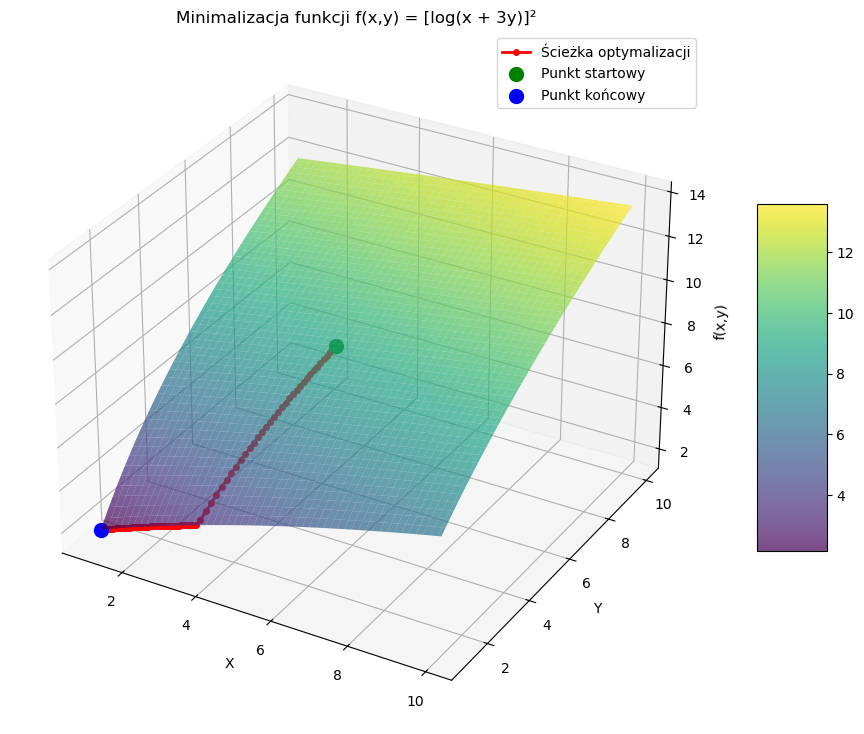

Znalezione minimum: x = 1.000000, y = 1.000000
Wartość funkcji w minimum: f(x,y) = 1.921812

Gradienty sieci neuronowej:
dW2:
[[0.11523835 0.17127426]]

db2:
[[-1.01727068]]

dW1:
[[-0.06666955 -0.1333391 ]
 [-0.05909728 -0.11819457]]

db1:
[[-0.06666955]
 [-0.05909728]]



In [3]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from autograd import grad
import autograd.numpy as anp

# ================= CZĘŚĆ 1: Minimalizacja funkcji metodą gradientu =================

# Definicja funkcji f(x,y) = [log(x + 3y)]^2
def f(params):
    x, y = params
    return (anp.log(x + 3*y))**2

# Obliczanie gradientu funkcji
grad_f = grad(f)

# Parametry metody gradientu
learning_rate = 0.1
max_iterations = 100
tolerance = 1e-6

# Punkt startowy
params = anp.array([5.0, 5.0])
trajectory = [(params[0], params[1], f(params))]

# Algorytm gradientu prostego
for _ in range(max_iterations):
    # Oblicz gradient
    gradient = grad_f(params)
    
    # Aktualizacja parametrów
    params_new = params - learning_rate * gradient
    
    # Projekcja na dziedzinę [1,10]x[1,10]
    params_new = anp.clip(params_new, 1, 10)
    
    # Warunek stopu
    if anp.linalg.norm(params_new - params) < tolerance:
        params = params_new
        trajectory.append((params[0], params[1], f(params)))
        break
        
    params = params_new
    trajectory.append((params[0], params[1], f(params)))

# Przygotowanie danych do wizualizacji
x_vals = np.linspace(1, 10, 100)
y_vals = np.linspace(1, 10, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f([X, Y])

traj_x, traj_y, traj_z = zip(*trajectory)

# Wizualizacja 3D
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Powierzchnia funkcji
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, edgecolor='none')

# Trajektoria optymalizacji
ax.plot(traj_x, traj_y, traj_z, 'r-', marker='o', markersize=4, linewidth=2, label='Ścieżka optymalizacji')

# Punkt startowy i końcowy
ax.scatter(traj_x[0], traj_y[0], traj_z[0], color='green', s=100, label='Punkt startowy')
ax.scatter(traj_x[-1], traj_y[-1], traj_z[-1], color='blue', s=100, label='Punkt końcowy')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x,y)')
ax.set_title('Minimalizacja funkcji f(x,y) = [log(x + 3y)]²')
ax.legend()
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

# Wyniki minimalizacji
print(f"Znalezione minimum: x = {params[0]:.6f}, y = {params[1]:.6f}")
print(f"Wartość funkcji w minimum: f(x,y) = {f(params):.6f}")

# ================= CZĘŚĆ 2: Obliczanie gradientów sieci neuronowej =================

# Parametry sieci
nn_architecture = [
    {"input_dim": 2, "output_dim": 2, "activation": "tanh"},
    {"input_dim": 2, "output_dim": 1, "activation": "tanh"}
]

# Inicjalizacja parametrów
def init_params(architecture):
    params = {}
    for idx, layer in enumerate(architecture):
        layer_idx = idx + 1
        input_dim = layer["input_dim"]
        output_dim = layer["output_dim"]
        
        params[f'W{layer_idx}'] = np.random.randn(output_dim, input_dim) * 0.1
        params[f'b{layer_idx}'] = np.zeros((output_dim, 1))
    return params

# Funkcje aktywacji
def tanh(Z):
    return np.tanh(Z)

def tanh_derivative(Z):
    return 1 - np.tanh(Z)**2

# Forward propagation
def forward_propagation(X, params, architecture):
    memory = {}
    A = X
    
    for idx, layer in enumerate(architecture):
        layer_idx = idx + 1
        A_prev = A
        W = params[f'W{layer_idx}']
        b = params[f'b{layer_idx}']
        activation = layer["activation"]
        
        Z = np.dot(W, A_prev) + b
        
        if activation == "tanh":
            A = tanh(Z)
        else:
            A = Z
        
        memory[f'A{idx}'] = A_prev
        memory[f'Z{layer_idx}'] = Z
    
    return A, memory

# Backward propagation (MSE loss)
def backward_propagation(Y_hat, Y, memory, params, architecture):
    grads = {}
    # Dla MSE: dL/dY_hat = Y_hat - Y
    dA = Y_hat - Y
    
    for layer_idx_prev in reversed(range(len(architecture))):
        layer_idx = layer_idx_prev + 1
        layer = architecture[layer_idx_prev]
        activation = layer["activation"]
        
        A_prev = memory[f'A{layer_idx_prev}']
        Z = memory[f'Z{layer_idx}']
        W = params[f'W{layer_idx}']
        
        if activation == "tanh":
            dZ = dA * tanh_derivative(Z)
        else:
            dZ = dA
        
        m = A_prev.shape[1]
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA = np.dot(W.T, dZ)
        
        grads[f'dW{layer_idx}'] = dW
        grads[f'db{layer_idx}'] = db
    
    return grads

# Dane testowe
X = np.array([[1.0, 2.0]])  # 1 próbka, 2 cechy (kształt: 1x2)
Y = np.array([[1.0]])        # Oczekiwana wartość (kształt: 1x1)

# Inicjalizacja i uruchomienie
params = init_params(nn_architecture)
Y_hat, memory = forward_propagation(X.T, params, nn_architecture)  # Transpozycja dla zgodności kształtów
grads = backward_propagation(Y_hat, Y, memory, params, nn_architecture)

# Wyświetlenie gradientów
print("\nGradienty sieci neuronowej:")
for key, value in grads.items():
    print(f"{key}:\n{value}\n")